In [2]:
import os 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm 
import glob
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
batch_size=1
# patch_size=32
lr = 0.0002
crit_repeats = 5
c_lambda = 10

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

In [ ]:
!wget "http://www.vision.ee.ethz.ch/ntire18/o-haze/O-HAZE.zip"

--2021-10-04 10:54:52--  http://www.vision.ee.ethz.ch/ntire18/o-haze/O-HAZE.zip
Resolving www.vision.ee.ethz.ch (www.vision.ee.ethz.ch)... 129.132.19.216, 2001:67c:10ec:254::216
Connecting to www.vision.ee.ethz.ch (www.vision.ee.ethz.ch)|129.132.19.216|:80... connected.
HTTP request sent, awaiting response... 301 
Location: https://data.vision.ee.ethz.ch/cvl/ntire18//o-haze/O-HAZE.zip [following]
--2021-10-04 10:54:53--  https://data.vision.ee.ethz.ch/cvl/ntire18//o-haze/O-HAZE.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 573320339 (547M) [application/zip]
Saving to: ‘O-HAZE.zip’

O-HAZE.zip          100%[===================>] 546.76M  10.6MB/s    in 54s     

2021-10-04 10:55:49 (10.1 MB/s) - ‘O-HAZE.zip’ saved [573320339/573320339]



In [ ]:
!unzip "/content/O-HAZE.zip"

Archive:  /content/O-HAZE.zip
   creating: # O-HAZY NTIRE 2018/
   creating: # O-HAZY NTIRE 2018/GT/
 extracting: # O-HAZY NTIRE 2018/GT/01_outdoor_GT.jpg  
  inflating: # O-HAZY NTIRE 2018/GT/02_outdoor_GT.jpg  
  inflating: # O-HAZY NTIRE 2018/GT/03_outdoor_GT.JPG  
  inflating: # O-HAZY NTIRE 2018/GT/04_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/05_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/06_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/07_outdoor_GT.jpg  
  inflating: # O-HAZY NTIRE 2018/GT/08_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/09_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/10_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/11_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/12_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/13_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/14_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/15_outdoor_GT.jpg  
 extracting: # O-HAZY NTIRE 2018/GT/16_outdoor_GT.jpg  
 ex

In [ ]:
!cd "/content/# O-HAZY NTIRE 2018/GT";rm -r ".ipynb_checkpoints"

In [4]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import os

In [9]:
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
    
])

In [ ]:
class patch_dataset(Dataset):

  def __init__(self, dataset_root, transforms=None):
    
    self.transforms = transforms
    self.dataset_root = dataset_root
    self.GT_files = os.listdir(os.path.join(dataset_root, "GT"))
    # self.hazy = os.listdir(os.path.join(dataset_root, "hazy"))
    # GT_path = os.path.join(dataset_root, "GT")
    # hazy_path = os.path.join(dataset_root, "hazy")

    # self.pairs = []

    # for folder in tqdm(os.listdir(GT_path)):

    #   for image_name in os.listdir(os.path.join(GT_path, folder)):
        
    #     hazy_image_name = image_name.split(".")[0].split("_")
    #     hazy_image_name[2] = "hazy"
    #     hazy_image_name = "_".join(hazy_image_name)
    #     hazy_image_name = hazy_image_name + ".jpg"

    #     folder_hazy = folder.split("_")
    #     folder_hazy[2] = "hazy"
    #     folder_hazy = "_".join(folder_hazy)
        

    #     hazy = os.path.join(hazy_path, folder_hazy, hazy_image_name)
    #     gt = os.path.join(GT_path, folder, image_name)

    #     self.pairs.append((hazy, gt))
      

  def __getitem__(self, index):
    
    # haze_path, gt_path = self.pairs[index]

    # hazed_image = np.array(Image.open(haze_path))
    # hazed_image = hazed_image[:, :, 0] # Red Channel
    # hazed_image = Image.fromarray(hazed_image)

    # gt_image = np.array(Image.open(gt_path))
    # gt_image = gt_image[:, :, 0] # Red Channel
    # gt_image = Image.fromarray(gt_image)

    GT_path = self.GT_files[index]
    hazy_path = GT_path.split("_")[0] + "_outdoor_hazy.jpg"

    GT_image = Image.open(os.path.join(self.dataset_root, "GT", GT_path))
    hazy_image = Image.open(os.path.join(self.dataset_root, "hazy", hazy_path))

    if self.transforms != None :
      hazed_image = self.transforms(hazy_image)
      gt_image = self.transforms(GT_image)

    
    return (hazed_image, gt_image)
    
  
  def __len__(self):
    return len(self.GT_files)

In [ ]:
dataset = patch_dataset("/content/# O-HAZY NTIRE 2018", transform)

In [ ]:
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## DataLoader

## Loss

## Training

In [21]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_tensor_images(image_tensor, num_images=25, size=(3, 32, 32)):

  plt.figure(figsize=(8, 8))
  image_tensor = (image_tensor + 1) / 2 # between 0 and 1 
  image_tensor = image_tensor.cpu().detach()

  image_grid = make_grid(image_tensor[:num_images], nrow=5)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()


In [ ]:
import torchvision.models as models

In [ ]:
vgg_pretrained_features = models.vgg16(pretrained=True).features
feature_extractor = nn.Sequential()

for i in range(12):
  feature_extractor.add_module(str(i), vgg_pretrained_features[i])

for module in feature_extractor:
  for param in module.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

## Generator and Discriminator

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        haze_class = models.densenet121(pretrained=True)

        ############# Block0-down  ##############
        self.conv0 = haze_class.features.conv0
        self.relu0 = haze_class.features.relu0
        self.pool0 = haze_class.features.pool0

        ############# Block1-down ##############
        self.dense_block1 = haze_class.features.denseblock1
        self.trans_block1 = haze_class.features.transition1

        ############# Block2-down ##############
        self.dense_block2 = haze_class.features.denseblock2
        self.trans_block2 = haze_class.features.transition2

        ############# Block3-down ##############
        self.dense_block3 = haze_class.features.denseblock3
        self.trans_block3 = haze_class.features.transition3
        self.res31 = BasicResBlock(512, 512)
        self.res32 = BasicResBlock(512, 512)

        ############# Block4-up ##############
        self.dense_block4 = BottleneckBlock(512, 256)
        self.trans_block4 = TransitionBlock(768, 128)
        self.res41 = BasicResBlock(387, 387)
        self.res42 = BasicResBlock(387, 387)

        ############# Block3-up ##############
        self.dense_block5 = BottleneckBlock(387, 256)
        self.trans_block5 = TransitionBlock(643, 128)
        self.res51 = BasicResBlock(259, 259)
        self.res52 = BasicResBlock(259, 259)

        ############# Block2-up ##############
        self.dense_block6 = BottleneckBlock(259, 128)
        self.trans_block6 = TransitionBlock(387, 64)
        self.res61 = BasicResBlock(67, 67)
        self.res62 = BasicResBlock(67, 67)

        ############# Block1-up ##############
        self.dense_block7 = BottleneckBlock(67, 64)
        self.trans_block7 = TransitionBlock(131, 32)
        self.res71 = BasicResBlock(35, 35)
        self.res72 = BasicResBlock(35, 35)

        ############# Block0-up ##############
        self.dense_block8 = BottleneckBlock(35, 32)
        self.trans_block8 = TransitionBlock(67, 16)

        # multi-scale
        self.conv_refin = nn.Conv2d(19, 20, 3, 1, 1)
        self.refout = nn.Conv2d(20, 3, kernel_size=3, stride=1, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.tanh = nn.Tanh()

    def forward(self, x):
        ## input: 1024 x 1024

        x0 = self.pool0(self.relu0(self.conv0(x)))  # 256 x 256

        x1 = self.dense_block1(x0)  # 256 x 256

        x1 = self.trans_block1(x1)  # 128 x 128

        x2 = self.trans_block2(self.dense_block2(x1))  # 64 x 64

        x3 = self.trans_block3(self.dense_block3(x2))  # 32 x 32
        x3 = self.res31(x3)  # 32 x 32
        x3 = self.res32(x3)  # 32 x 32

        x4 = self.trans_block4(self.dense_block4(x3))  # 64 x 64
        x43 = F.avg_pool2d(x, 16)  # 64 x 64
        x42 = torch.cat([x4, x2, x43], 1)  # 64 x 64
        x42 = self.res41(x42)  # 64
        x42 = self.res42(x42)  # 64

        x5 = self.trans_block5(self.dense_block5(x42))  # 128
        x53 = F.avg_pool2d(x, 8)  # 128
        x52 = torch.cat([x5, x1, x53], 1)  # 128
        x52 = self.res51(x52)  # 128
        x52 = self.res52(x52)  # 128

        x6 = self.trans_block6(self.dense_block6(x52))  # 256
        x63 = F.avg_pool2d(x, 4)  # 256
        x62 = torch.cat([x6, x63], 1)  # 256
        x62 = self.res61(x62)  # 256
        x6 = self.res62(x62)  # 256

        x7 = self.trans_block7(self.dense_block7(x6))  # 512
        x73 = F.avg_pool2d(x, 2)  # 512
        x72 = torch.cat([x7, x73], 1)  # 512
        x72 = self.res71(x72)  # 512
        x7 = self.res72(x72)  # 512

        x8 = self.trans_block8(self.dense_block8(x7))  # 1024
        x8 = torch.cat([x8, x], 1)  # 1024

        x9 = self.relu(self.conv_refin(x8))  # 1024

        dehaze = self.tanh(self.refout(x9))

        return dehaze


class BottleneckBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(BottleneckBlock, self).__init__()
        inter_planes = out_planes * 4
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_planes, inter_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.conv2 = nn.Conv2d(inter_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(self.relu(x))
        out = self.conv2(self.relu(out))
        return torch.cat([x, out], 1)


class TransitionBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(TransitionBlock, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.ConvTranspose2d(in_planes, out_planes, kernel_size=1, stride=1,
                                        padding=0, bias=False)

    def forward(self, x):
        out = self.conv1(self.relu(x))
        return F.interpolate(out, scale_factor=2)


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicResBlock(nn.Module):
    def __init__(self, inplanes, planes):
        super(BasicResBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)

        out = self.conv2(out)

        out += residual
        out = self.relu(out)

        return out


class Discriminator(nn.Module):
    def __init__(self, nc=3, nf=36):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(nc, nf, kernel_size=4, stride=2, padding=1, bias=False),  # 36 x 512 x 512
            nn.LeakyReLU(0.2, inplace=True),
            DBlock(nf, nf * 2),  # 72 x 256 x 256
            DBlock(nf * 2, nf * 4),  # 144 x 128 x 128
            DBlock(nf * 4, nf * 8),  # 288 x 64 x 64
            DBlock(nf * 8, nf * 8),  # 288 x 32 x 632
            nn.Conv2d(nf * 8, nf * 8, 4, 1, 1, bias=False),  # 288 x 31 x 31
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(nf * 8, 1, 4, 1, 1, bias=False),  # 288 x 30 x 30
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.main(x)
        return output

    def requires_grad(self, req):
        for param in self.parameters():
            param.requires_grad = req


class DBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(DBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        output = self.main(x)
        return output

In [ ]:
gen = Generator()
disc = Discriminator()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
criterion = nn.BCELoss()
l1Loss = nn.L1Loss()
mseLoss = nn.MSELoss()
disc_optim = torch.optim.Adam(disc.parameters())
gen_optim = torch.optim.Adam(gen.parameters())

In [ ]:
n_epochs = 5

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/dehazing_checkpoints/ckpt_epoch_4_iter_20.pth")
gen_optim.load_state_dict(checkpoint["generator_optimizer_dict"])
disc_optim.load_state_dict(checkpoint["disc_optimizer_dict"])
disc.load_state_dict(checkpoint["discriminator_state_dict"])
gen.load_state_dict(checkpoint["generator_state_dict"])

<All keys matched successfully>

  0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


recon_loss 0.22689659893512726
perceptual_loss 0.5426647663116455
gen_loss 0.29667988419532776
disc loss 0.6956930160522461


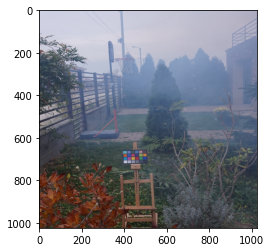

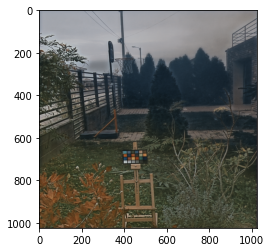

recon_loss 0.16340577602386475
perceptual_loss 0.4598025679588318
gen_loss 0.37458497285842896
disc loss 0.6878644227981567


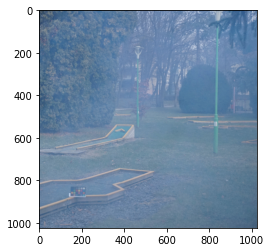

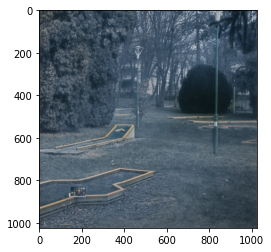

recon_loss 0.08730306476354599
perceptual_loss 0.2277713418006897
gen_loss 0.3372785151004791
disc loss 0.6891487836837769


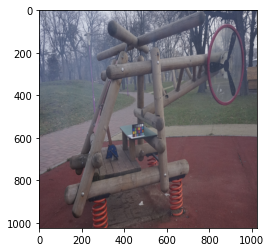

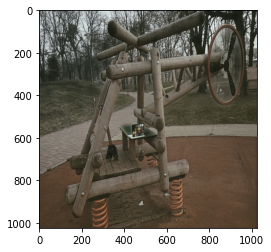

  0%|          | 0/45 [00:00<?, ?it/s]

recon_loss 0.16330312192440033
perceptual_loss 0.39275437593460083
gen_loss 0.35830119252204895
disc loss 0.6949334740638733


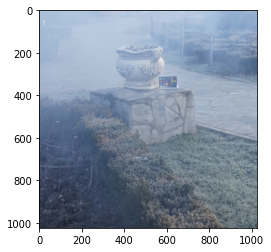

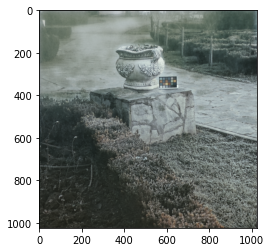

recon_loss 0.2735302746295929
perceptual_loss 0.8180704116821289
gen_loss 0.4223003089427948
disc loss 0.6632914543151855


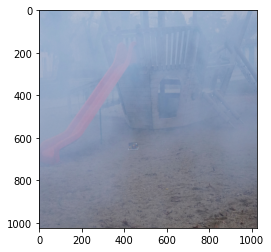

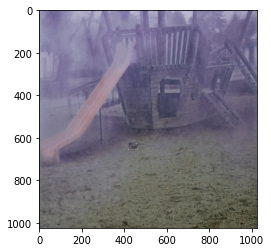

recon_loss 0.11658793687820435
perceptual_loss 0.5344802141189575
gen_loss 0.3815896809101105
disc loss 0.6875748634338379


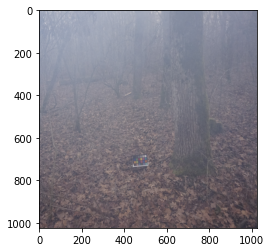

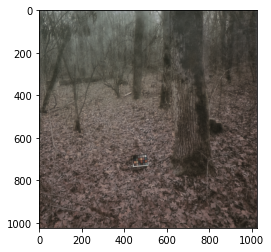

  0%|          | 0/45 [00:00<?, ?it/s]

recon_loss 0.10620563477277756
perceptual_loss 0.3200254440307617
gen_loss 0.3953445553779602
disc loss 0.6960440874099731


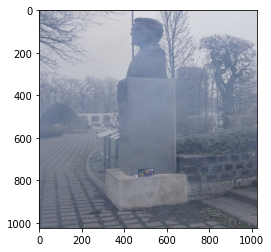

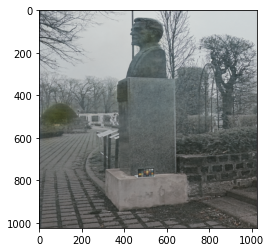

recon_loss 0.2832982838153839
perceptual_loss 0.5139079689979553
gen_loss 0.3889366686344147
disc loss 0.6466169357299805


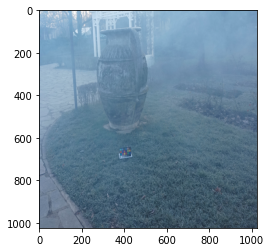

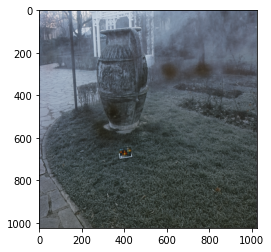

recon_loss 0.2105272263288498
perceptual_loss 1.1307984590530396
gen_loss 0.36225321888923645
disc loss 0.7026517987251282


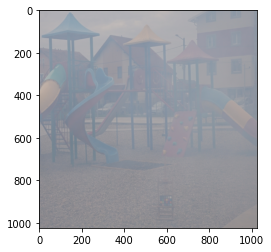

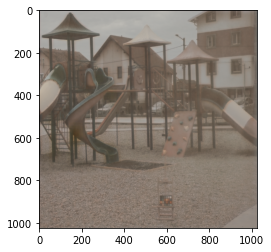

  0%|          | 0/45 [00:00<?, ?it/s]

recon_loss 0.1501794308423996
perceptual_loss 0.68275386095047
gen_loss 0.3203592598438263
disc loss 0.695209264755249


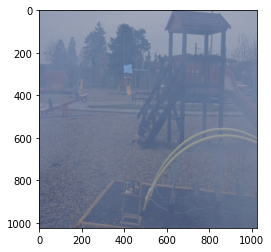

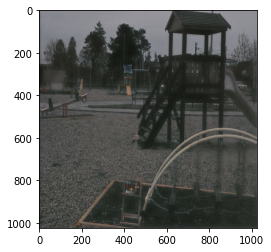

In [ ]:
for epoch in range(5, 50):

  for iteration, (hazy, dehazed) in enumerate(tqdm(train_loader)):

    # Training Generator
    gen_optim.zero_grad()

    gen_pred_fake = gen(hazy)

    # perceptual Loss
    perceptual_loss = 0.5 * mseLoss(feature_extractor(gen_pred_fake), feature_extractor(dehazed))
    perceptual_loss.backward(retain_graph=True)


    # reconstruction loss
    recon_loss = l1Loss(gen_pred_fake, dehazed)
    recon_loss.backward(retain_graph=True)

    # GAN Loss
    disc_pred_fake = disc(gen_pred_fake)
    labels = torch.ones_like(disc_pred_fake)
    gen_loss = 0.5 * criterion(disc_pred_fake, labels)
    gen_loss.backward()

    # update parameters
    gen_optim.step()

    # Training Discriminator
    disc_optim.zero_grad()

    gen_pred_fake = gen(hazy).detach()
    disc_pred_fake = disc(gen_pred_fake)
    fake_loss = criterion(disc_pred_fake, torch.zeros_like(disc_pred_fake))

    disc_pred_real = disc(dehazed)
    real_loss = criterion(disc_pred_real, torch.ones_like(disc_pred_real))

    loss = 1/2 * (fake_loss + real_loss)

    loss.backward()

    disc_optim.step()

    if iteration % 20 == 0:

      print("recon_loss", recon_loss.item())
      print("perceptual_loss", perceptual_loss.item())
      print("gen_loss", gen_loss.item())
      print("disc loss", loss.item())

      show_tensor_images(hazy)
      show_tensor_images(gen(hazy))

      torch.save({
          "generator_state_dict": gen.state_dict(),
          "generator_optimizer_dict": gen_optim.state_dict(),
          "discriminator_state_dict": disc.state_dict(),
          "disc_optimizer_dict": disc_optim.state_dict(),
      }, "/content/drive/MyDrive/dehazing_checkpoints/ckpt_epoch_{}_iter_{}.pth".format(epoch, iteration))

In [8]:
ckpt = torch.load("/content/drive/MyDrive/dehazing_checkpoints/ckpt_epoch_8_iter_0.pth")
gen = Generator()
gen.load_state_dict(ckpt["generator_state_dict"])

<All keys matched successfully>

In [32]:
img = Image.open("/content/img000460.jpg")
img = transform(img)

img.shape

torch.Size([3, 1024, 1024])

In [33]:
out = gen(img.unsqueeze(dim=0))
out.shape

torch.Size([1, 3, 1024, 1024])

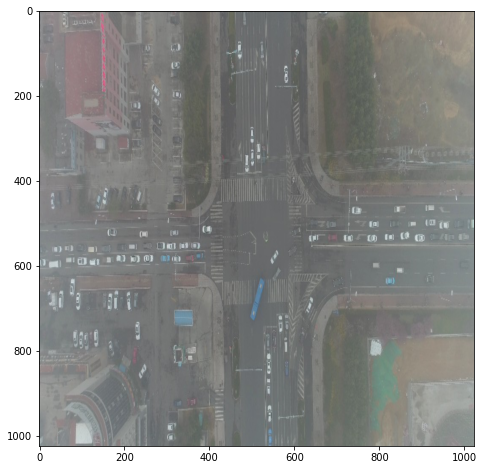

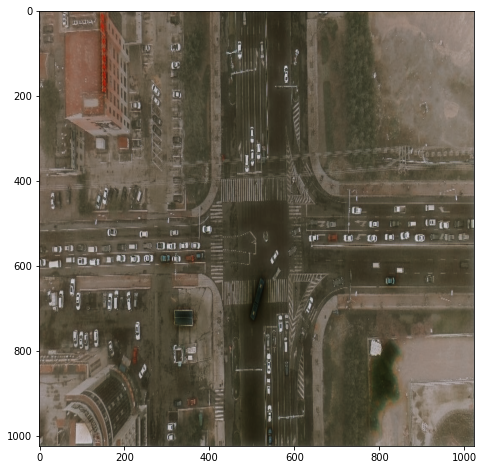

In [34]:
show_tensor_images(img)
show_tensor_images(out)